In [2]:
# dataset: https://www.kaggle.com/datasets/lumaatabbaa/vr-eyes-emotions-dataset-vreed
# research paper: https://dl.acm.org/doi/abs/10.1145/3495002
# reference: https://www.kaggle.com/code/ddzsotjan/et-sig-et-and-ai-workshop-notebook

# objective: to increase model robustness using only eye-tracking data and non-NN machine learning methods


In [33]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns

# df_ET : df Eye Tracking
df_ET = pd.read_csv('./data/EyeTracking.csv')
df_ECG = pd.read_csv('./data/ECG.csv')
df_GSR = pd.read_csv('./data/GSR.csv')
labels = df_ET['Quad_Cat']

# The datasets are aligned such that corresponding rows in each dataset refer to the same experimental instance
df_labels = pd.concat([df_ET['Quad_Cat'], df_ECG['Quad_Cat'], df_GSR['Quad_Cat']], axis = 1)

In [34]:
# check that labels in each dataset do indeed correspond with each other
df_labels.corr()

,Quad_Cat,Quad_Cat,Quad_Cat
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0
Quad_Cat,1.0,1.0,1.0


In [35]:
# drop labels in each data set
df_ET = df_ET.drop(columns=['Quad_Cat'])
df_ECG = df_ECG.drop(columns=['Quad_Cat'])
df_GSR = df_GSR.drop(columns=['Quad_Cat'])

df_ET = df_ET.add_prefix('ET_')
df_ECG = df_ECG.add_prefix('ECG_')
df_GSR = df_GSR.add_prefix('GSR_')

In [36]:
df_COMBINED = pd.concat([df_ET, df_ECG, df_GSR], axis = 1)

In [37]:
df_COMBINED.corr()

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
ET_Num_of_Fixations,1.000000,-0.604457,-0.734658,0.172732,-0.718275,-0.410209,0.999119,0.310356,0.343761,0.190974,...,0.001587,0.057426,-0.031133,-0.082772,-0.046696,-0.013711,-0.047219,-0.074388,-0.073778,-0.062173
ET_Mean_Fixation_Duration,-0.604457,1.000000,0.886562,-0.279585,0.706204,0.358865,-0.602993,-0.230428,-0.255638,-0.208530,...,0.044787,0.030092,-0.061387,0.057892,0.019307,-0.069916,-0.040893,-0.053944,-0.051923,-0.038809
ET_SD_Fixation_Duration,-0.734658,0.886562,1.000000,-0.080770,0.918578,0.339606,-0.732574,-0.248090,-0.251009,-0.182559,...,0.029556,0.021072,-0.045730,0.066747,0.025560,-0.059350,-0.025205,-0.011441,-0.012723,-0.012616
ET_Skew_Fixation_Duration,0.172732,-0.279585,-0.080770,1.000000,0.244157,-0.181054,0.175485,0.173949,0.233899,0.148649,...,-0.084109,0.022980,0.080460,-0.008288,-0.012130,0.071840,0.063246,0.015385,0.012661,-0.082032
ET_Max_Fixation_Duration,-0.718275,0.706204,0.918578,0.244157,1.000000,0.283682,-0.714371,-0.228214,-0.198350,-0.101977,...,-0.005872,0.012087,-0.017325,0.062715,0.022004,-0.032797,-0.000485,-0.006487,-0.005771,-0.056692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GSR_Minimum,-0.013711,-0.069916,-0.059350,0.071840,-0.032797,-0.025304,-0.016354,0.111894,0.068558,-0.001583,...,0.132205,-0.006347,0.982255,0.285223,0.109878,1.000000,0.943303,0.309728,0.281482,0.284999
GSR_Maximum,-0.047219,-0.040893,-0.025205,0.063246,-0.000485,0.020391,-0.048629,0.036852,-0.002272,0.022946,...,0.140694,0.023735,0.980993,0.573800,0.370272,0.943303,1.000000,0.378274,0.349991,0.329451
GSR_Number of Peaks,-0.074388,-0.053944,-0.011441,0.015385,-0.006487,0.089969,-0.081121,0.137264,0.103710,-0.064282,...,-0.043895,0.014925,0.368421,0.339429,0.250338,0.309728,0.378274,1.000000,0.985503,0.848455
GSR_Number of Valleys,-0.073778,-0.051923,-0.012723,0.012661,-0.005771,0.087127,-0.080180,0.128050,0.101421,-0.049485,...,-0.043487,0.018899,0.340599,0.328542,0.240705,0.281482,0.349991,0.985503,1.000000,0.815625


<Axes: >

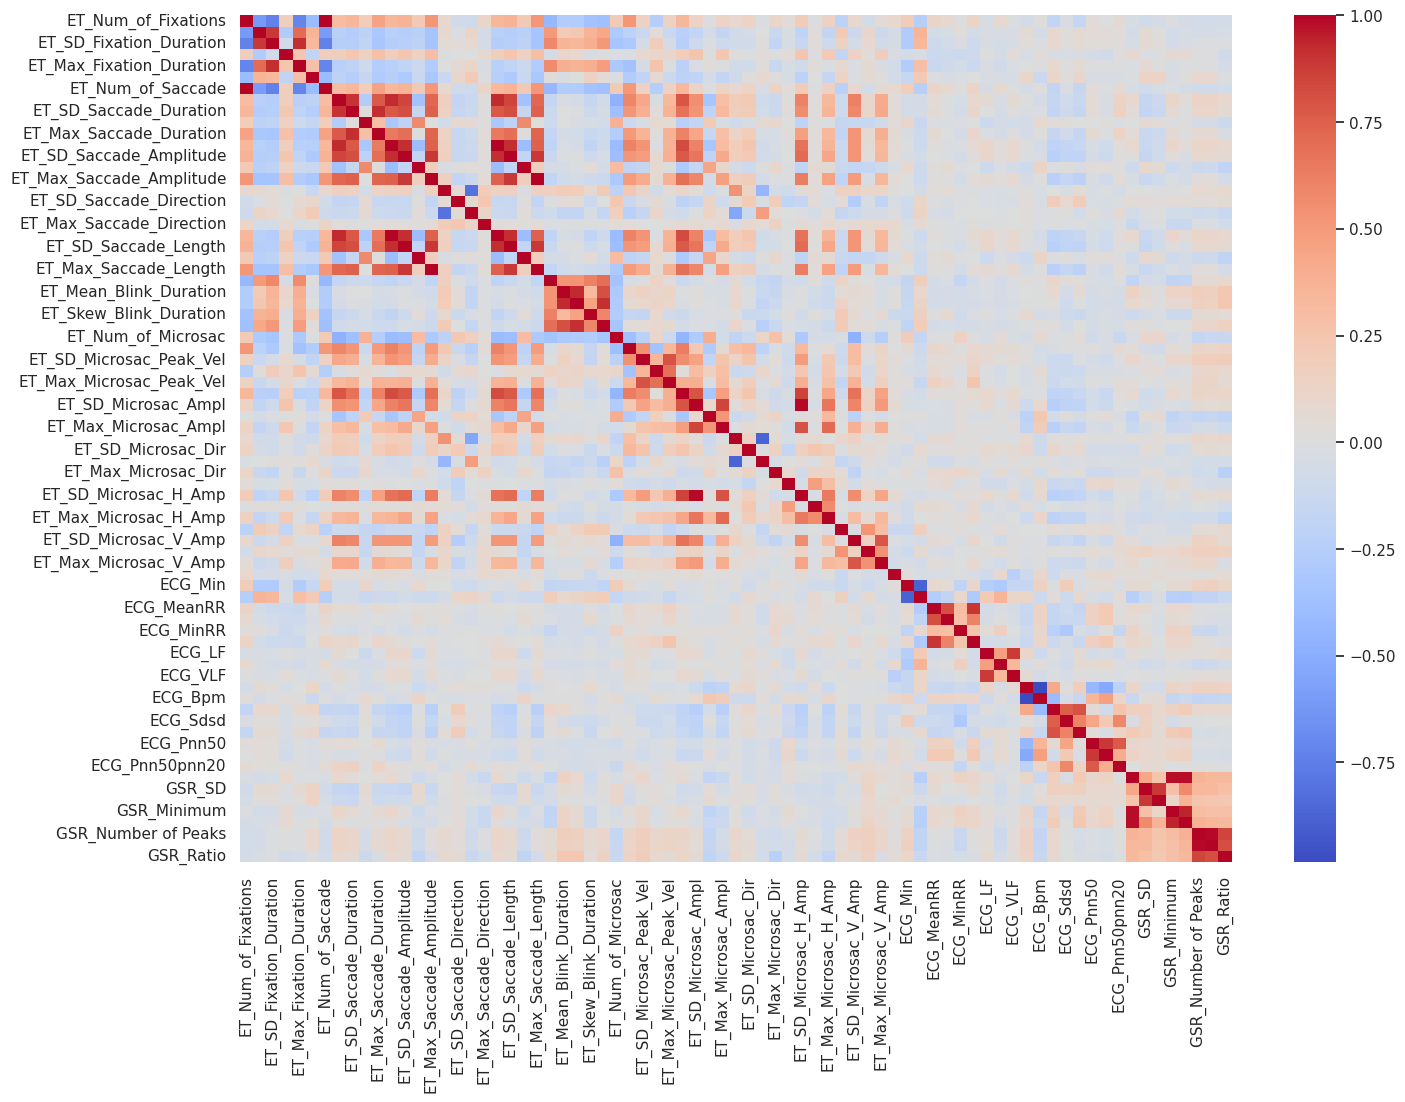

In [38]:
plt.figure(figsize=(16, 11))
sns.set(
    rc = {
        'font.size':9
    }
)
sns.heatmap(df_COMBINED.corr(), annot=False, cmap="coolwarm")

In [39]:
from sklearn.preprocessing import StandardScaler

df_ET = df_ET.fillna(df_ET.mean())
df_ECG = df_ECG.fillna(df_ECG.mean())
df_GSR = df_GSR.fillna(df_GSR.mean())
df_COMBINED = df_COMBINED.fillna(df_COMBINED.mean())

df_ET = pd.DataFrame(StandardScaler().fit_transform(df_ET), columns=df_ET.columns)
df_COMBINED = pd.DataFrame(StandardScaler().fit_transform(df_COMBINED), columns=df_COMBINED.columns)


In [40]:
df_COMBINED

,ET_Num_of_Fixations,ET_Mean_Fixation_Duration,ET_SD_Fixation_Duration,ET_Skew_Fixation_Duration,ET_Max_Fixation_Duration,ET_First_Fixation_Duration,ET_Num_of_Saccade,ET_Mean_Saccade_Duration,ET_SD_Saccade_Duration,ET_Skew_Saccade_Duration,...,ECG_pnn20,ECG_Pnn50pnn20,GSR_Mean,GSR_SD,GSR_Variance,GSR_Minimum,GSR_Maximum,GSR_Number of Peaks,GSR_Number of Valleys,GSR_Ratio
0,1.621535,-0.454633,-0.679505,-0.155565,-0.779439,-0.442632,1.658537,0.458853,0.628405,0.164549,...,0.171762,0.898107,-1.370422,-0.992554,-0.489271,-1.294260,-1.429851,-0.799596,-0.775370,-0.888829
1,0.424474,-0.271174,-0.376489,0.132527,-0.406528,-0.730612,0.385983,0.171314,0.114999,-1.122387,...,0.104844,0.950112,-0.969713,0.047432,-0.168829,-1.140809,-0.874666,0.176780,0.232863,0.300975
2,0.594714,-0.326916,-0.371202,-0.641641,-0.631543,-0.700060,0.529733,0.728825,0.693398,-0.219489,...,-0.204400,0.950112,-1.268068,-0.210397,-0.287093,-1.489450,-1.302003,0.452463,0.517541,1.129431
3,0.386542,-0.251685,-0.086130,1.163586,0.111722,-0.399063,0.364050,-0.095594,0.118233,0.313133,...,-0.576708,0.588066,-1.001626,0.512500,0.109214,-1.316195,-0.777628,0.475437,0.541264,0.327415
4,0.985451,-0.338016,-0.502166,-0.392220,-0.636350,-0.528973,0.981254,-0.330977,-0.288409,0.417352,...,0.277461,0.792718,-1.435824,-0.952979,-0.484699,-1.366812,-1.495501,-0.167823,-0.122984,-0.620021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307,0.335267,-0.200305,-0.292216,0.112405,-0.222425,1.064480,0.310200,-0.888011,-0.592116,0.115821,...,0.670958,-0.541336,0.795495,-0.403867,-0.359028,0.934313,0.657822,-0.150593,-0.366146,-0.174947
308,-1.056094,0.142865,0.306460,-0.488896,0.399434,0.850355,-1.002451,0.654930,0.291824,0.197774,...,2.651847,0.806680,1.543549,3.590615,4.049020,0.703250,1.732379,0.015966,0.066801,-0.368841
309,0.682084,-0.388734,-0.557590,0.365139,-0.619474,-0.668181,0.674444,1.693993,1.910089,0.114572,...,1.586275,0.307857,0.198878,-0.363832,-0.345325,0.286824,0.043708,-0.087415,0.149832,-0.465787
310,0.247140,-0.250764,-0.336645,0.005392,-0.381879,-0.597248,0.191091,0.456800,1.316528,0.977202,...,1.986626,0.848770,0.277601,-0.643029,-0.428033,0.427264,0.098143,0.044682,0.493818,0.679949


In [41]:
# drop highly correlated features; replicate for combined dataset
# TODO: Additional inspection please
corr_vars = ["ET_Mean_Fixation_Duration", "ET_Num_of_Saccade", "ET_Mean_Saccade_Amplitude", "ET_SD_Saccade_Amplitude", "ET_Skew_Saccade_Amplitude", "ET_Max_Saccade_Amplitude"]

df_ET.drop(corr_vars, axis=1, inplace=True)


In [42]:
# Convert Quad Cat to Valence
# TODO: deprecate this for final draft. Will be comparing methods for quad_cat prediction only
labels = pd.DataFrame(labels).replace({'Quad_Cat' : {1: 0}})
labels = labels.replace({'Quad_Cat' : {2: 1, 3: 1}})

In [43]:
labels = labels['Quad_Cat']
labels

0      0
1      0
2      0
3      1
4      0
      ..
307    1
308    0
309    0
310    1
311    1
Name: Quad_Cat, Length: 312, dtype: int64

In [44]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test =  train_test_split(df_ET, labels, test_size=0.1)

parameters = {'kernel':['linear'], 
              'C':np.logspace(-5, 5, 11, base=2),
              'gamma':np.logspace(-5, 5, 11, base=2)
             }
svc = SVC()
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')
grid.fit(X_train, y_train)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'C': np.float64(0.0625), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.7285714285714285


In [45]:
best_model = grid.best_estimator_
prediction = best_model.predict(X_test)

In [46]:
test_labels = np.array(y_test)
print(prediction)
print(test_labels)

[0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 0 0 1 1 1 1 1 0 1 1 0]
[1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1]


In [47]:
total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

0.59375


In [50]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.svm import SVC

parameters = {'kernel':['linear', 'rbf', 'poly'], 
              'C':np.logspace(-5, 10, 30, base=2),
              'gamma':np.logspace(-5, 10, 30, base=2)
             }
svc = SVC()
grid = GridSearchCV(svc, parameters, cv=10, scoring='accuracy')
grid.fit(df_COMBINED, labels)

best_params = grid.best_params_
best_score = grid.best_score_

print(best_params)
print(best_score)

{'C': np.float64(0.1876617977932919), 'gamma': np.float64(0.03125), 'kernel': 'linear'}
0.6801411290322581


In [20]:
# just for fun
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import warnings
from sklearn.exceptions import ConvergenceWarning

# please, no warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)
os.environ['PYTHONWARNINGS']='ignore'

##
X_train, X_test, y_train, y_test =  train_test_split(df_ET, labels, test_size=0.2)

mlp = MLPClassifier(max_iter=1000, random_state=42, verbose=False)

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],  
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],  
    'alpha': [0.0001, 0.001, 0.01],  
    'learning_rate': ['constant', 'adaptive'],  
    'learning_rate_init': [0.001, 0.01, 0.1],  
    'batch_size': ['auto', 64, 128], 
}

grid_search = GridSearchCV(mlp, param_grid, cv=5, n_jobs=-1, verbose=0)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)
print(grid_search.best_score_)

{'activation': 'tanh', 'alpha': 0.01, 'batch_size': 64, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'learning_rate_init': 0.1, 'solver': 'sgd'}
0.7791836734693879


In [48]:
best_model = grid_search.best_estimator_
prediction = best_model.predict(X_test)

In [49]:
test_labels = np.array(y_test)
print(prediction)
print(test_labels)

[0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1]
[1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 0 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 1]


In [50]:
total = len(np.array(prediction == test_labels))
correct = len(np.where(np.array(prediction == test_labels) == True)[0])
print(correct/total)

0.875


In [1]:
# grid_search.cv_results_['mean_test_score']

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier

# Parameter grid for AdaBoost
parameters = {
    'n_estimators': [100],  # Fixed at 500 estimators
    'learning_rate': np.logspace(-10, 0, 4)  # Vary the learning rate
}

# Initialize AdaBoostClassifier
ada = AdaBoostClassifier()

# Set up GridSearchCV with AdaBoost and 10-fold cross-validation
grid = GridSearchCV(ada, parameters, cv=10, scoring='accuracy')

# Fit the model using GridSearchCV
grid.fit(df_ET, labels)

# Retrieve the best parameters and the best score from the grid search
best_params = grid.best_params_
best_score = grid.best_score_

# Print the results
print(best_params)
print(best_score)

/mnt/d/CU_Boulder/CU_Boulder/MachineLearning1/Week7/CSCA5622_project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/mnt/d/CU_Boulder/CU_Boulder/MachineLearning1/Week7/CSCA5622_project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/mnt/d/CU_Boulder/CU_Boulder/MachineLearning1/Week7/CSCA5622_project/venv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/mnt/d/CU_Boulder/CU_Boulder/MachineLearning1/Week7/CSCA5622_project/venv/lib/p

{'learning_rate': np.float64(1.0), 'n_estimators': 100}
0.7048387096774194
